# Final Project: Autoencoder Model

In [18]:
import keras
import tensorflow as tf

from PIL import Image
from math import floor
import pandas as pd 
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [2]:
# Specify the image, annotations and destination path
imPath = 'IndustryBiscuit/Images'
anPath = 'IndustryBiscuit/Annotations.csv'
dsPath = 'IndustryBiscuit_Folders'

In [3]:
#Print first five images from train/ok folder
def show_images(path):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    for i in range(5):
        img = mpimg.imread(os.path.join(path, os.listdir(path)[i]))
        axes[i].imshow(img)
        axes[i].axis('off')
        print(img.shape)
    plt.show()

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


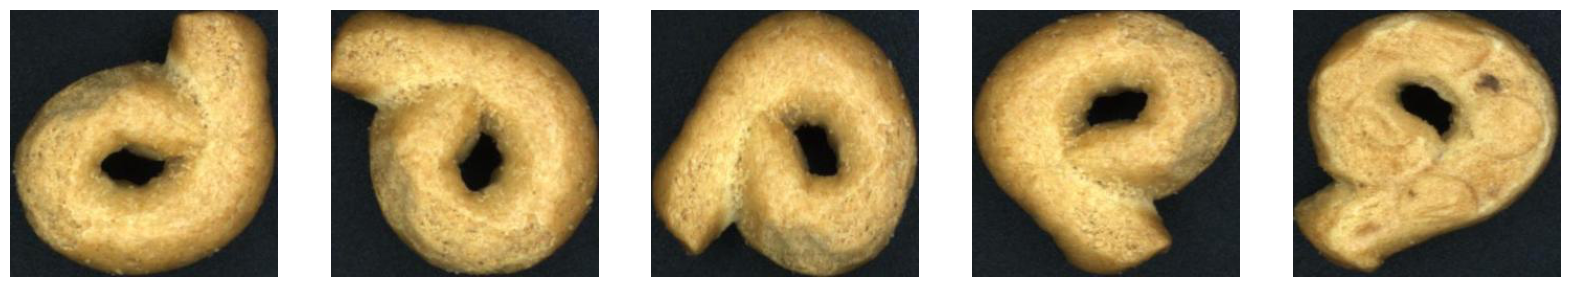

In [4]:
show_images(os.path.join(dsPath, 'train', 'ok'))

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


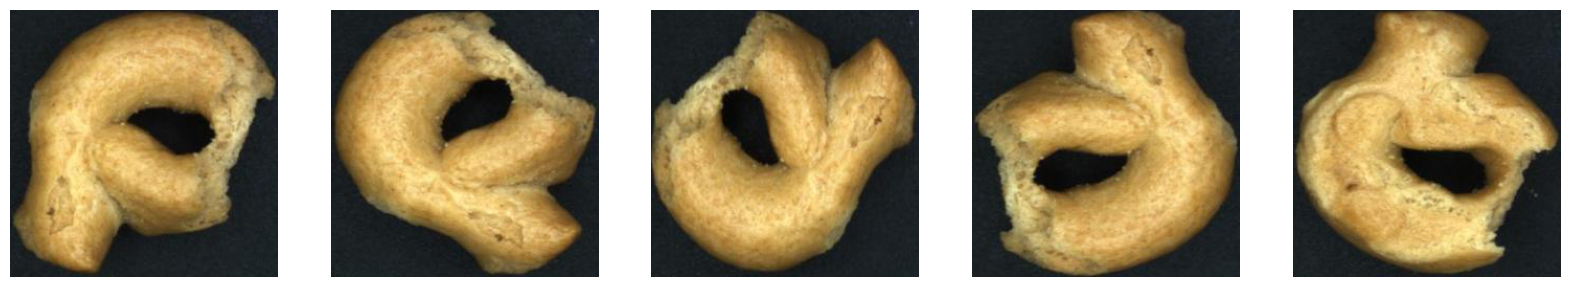

In [5]:
show_images(os.path.join(dsPath, 'train', 'nok'))

# Create Autoencoder Model

In [35]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    'IndustryBiscuit_Folders/train',
    target_size=IMAGE_SIZE[:2],
    batch_size=BATCH_SIZE,
    class_mode='input',
    classes=['ok'],
    shuffle=True
)

test_generator = train_datagen.flow_from_directory(
    'IndustryBiscuit_Folders/test',
    target_size=IMAGE_SIZE[:2],
    batch_size=1,
    class_mode='binary',  # will label 'nok'=0, 'ok'=1 by default
    shuffle=False
)


Found 1000 images belonging to 1 classes.
Found 400 images belonging to 2 classes.


In [137]:
def build_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # Compressed representation

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


In [37]:
len(train_generator)

32

In [38]:
x, y = next(iter(train_generator))
print(f"x shape: {x.shape}, y shape: {y.shape}")


x shape: (32, 256, 256, 3), y shape: (32, 256, 256, 3)


In [39]:
x, y = next(iter(test_generator))
print(f"x shape: {x.shape}, y shape: {y.shape}")


x shape: (1, 256, 256, 3), y shape: (1,)


In [143]:
autoencoder = build_autoencoder(input_shape=(256, 256, 3))
autoencoder.fit(
    train_generator,
    epochs=100,
    steps_per_epoch=len(train_generator)
)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 695ms/step - loss: 0.0603
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 833ms/step - loss: 0.0067
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 901ms/step - loss: 0.0031
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 963ms/step - loss: 0.0018
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 921ms/step - loss: 0.0015
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 956ms/step - loss: 0.0014
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 956ms/step - loss: 0.0013
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 0.0014
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 0.0011
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.0011
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 9.6288e-04
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 9.6980e-04
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 991ms/step - loss: 8.6388e-04
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 967ms/step - loss: 0.0011
Epoch 15/100
32/32 ━━━━━━━━━━━━━

In [144]:
from sklearn.metrics import precision_recall_curve

def compute_anomaly_scores(autoencoder, generator, true_labels=None, cost_fp=1, cost_fn=15.0):
    reconstruction_errors = []
    images = []

    # Compute reconstruction errors
    for i in range(len(generator)):
        img = generator[i][0]
        images.append(img)
        recon = autoencoder.predict(img)
        error = np.mean((img - recon) ** 2)
        reconstruction_errors.append(error)

    reconstruction_errors = np.array(reconstruction_errors)

    # If true labels are provided, optimize threshold based on costs
    if true_labels is not None:
        precision, recall, thresholds = precision_recall_curve(true_labels, reconstruction_errors)
        thresholds = np.append(thresholds, [reconstruction_errors.max() + 1])  # ensure thresholds align with precision/recall
        total_costs = [
            cost_fp * (1 - p) + cost_fn * (1 - r)
            for p, r in zip(precision, recall)
        ]
        best_idx = np.argmin(total_costs)
        threshold = thresholds[best_idx]
    else:
        # Default: fixed percentile threshold
        threshold = np.percentile(reconstruction_errors, 95)  # top 5% are anomalies

    # Predict anomaly based on threshold
    preds = (reconstruction_errors > threshold).astype(int)

    return preds, reconstruction_errors, threshold


In [145]:
true_labels = np.array([0 if path.split('\\')[0] == 'ok' else 1 for path in test_generator.filenames])

preds, errors, thresh = compute_anomaly_scores(autoencoder, test_generator, true_labels=true_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

In [146]:
from sklearn.metrics import classification_report

print(f"Threshold used: {thresh}")
print(classification_report(true_labels, preds))


Threshold used: 0.00036963168531656265
              precision    recall  f1-score   support

           0       0.93      0.07      0.12       200
           1       0.52      0.99      0.68       200

    accuracy                           0.53       400
   macro avg       0.72      0.53      0.40       400
weighted avg       0.72      0.53      0.40       400



In [147]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_labels, preds)

array([[ 13, 187],
       [  1, 199]], dtype=int64)